Combating Class Imbalance in a Clinical Dataset
===========================================================
Date: December 18, 2019 <br/>
Partners: Andy Jeong
Course: ECE414 -- Bayesian Machine Learning  <br/>
Instructor: Professor Sam Keene  <br/>

> **Dataset:** Parkinson's Disease Telemonitoring (from UCI Machine Learning Repository) <br/>
> **Application Project:** Pick an interesting application and explore how best to apply machine learning algorithms to solve it. <br/>
> **Goal:** data analysis, data-level and algorithm-level class imbalance handling <br/>

> ** Class Imbalance Classification, which often occurs with extreme skewness across many real-world domains (along with noise) **

In [1]:
import pandas as pd
import numpy as np
import math

# load data
df = pd.read_csv('../parkinsons_data/parkinsons_updrs.data', delimiter=',')

In [2]:
# suppress warnings 
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings(action='ignore')

In [3]:
# append the library for LIBSVM
import sys
sys.path.append('../libsvm/python')

In [4]:
# define functions for thresholding, extracting features and target, standardizing and plotting for visualization
df2 = df.copy()

from sklearn import preprocessing
from collections import Counter

# threshold the specified target attribute at the input value
def threshold(df, target_attr='total_UPDRS', value=8):
    update = df.copy()
    update[df[target_attr]<value] = -1 # less than threshold => negative class
    update[df[target_attr]>=value] = 1 # greater than threshold => positive class
    df.update(update[target_attr])
    
    # imbalance ratio = a proportion of samples in the number of majority class to the number of minority class
    neg = sum(update[target_attr]==-1)
    pos = sum(update[target_attr]==1)
    print(y_attr,"threshold:",value,":: -1's:",neg,"/ +1's",pos)
    if neg > pos:
        print("imbalance ratio (maj:min):", neg,":",pos, round(pos/neg*100,4),"%")
    elif pos > neg:
        print("imbalance ratio (maj:min):",pos,":",neg,"/", round(neg/pos*100,4),"%")

    return df, pos, neg

# extract useful features and target attribute
def X_Y_attr_extract(df, y_attr):  
    # separate columns
    ID = df.iloc[:,0]        # ignore patient ID
    times = df.iloc[:,3]     # ignore time
    age_sex = df.iloc[:,1:3] # discrete, categorial (per patient)
    UPDRS = df.iloc[:,4:6]   # target attributes
    attrs = df.iloc[:,6:]    # features
    
    X = pd.concat([age_sex, attrs], sort=False, axis=1)
    Y = df[y_attr] # total UPDRS
    
    return X, Y

# standardize the feature values by: z = (x - mean) / std
# using standard scaler --> normalize values to range [-1, 1]
def standardize(df):    
    result = df.copy()
    scaler = preprocessing.StandardScaler().fit(result) # standard scaler: [-1,1]
    standardized = pd.DataFrame(scaler.transform(result), columns=result.columns)
    
    return standardized

# take unique number from a list
def unique(list1):
    x = np.array(list1)
    unique_list = np.unique(x)
    return unique_list

# for visualization and interpreting the prediction results
def summary(Y_test, y_pred):
    from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_curve, auc
    from imblearn.metrics import geometric_mean_score
    import matplotlib.pyplot as plt
    %matplotlib inline

    # evaluation metrics we are interested in, for imbalanced datasets
    acc = accuracy_score(y_pred, Y_test)
    b_acc = balanced_accuracy_score(y_pred, Y_test)
    f1 = f1_score(y_pred, Y_test)
    gmean = geometric_mean_score(Y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(Y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='reference')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()    
    
    print('------summary statistics-------')
    print("acc: {:.4f} / balanced acc: {:.4f}, AUC: {:.4f}, F1: {:.4f}, g-mean: {:.4f}".format(acc,b_acc,auc(fpr, tpr),f1, gmean))

In [5]:
# apply thresholding and standarization to the data

# y_attr = 'motor_UPDRS'
y_attr = 'total_UPDRS'
thresh = 8
# threshold value ranges
# 7 to 54 for total_UPDRS
# 5 to 39 for motor_UPDRS
list_thresh = np.unique(unique(list(df[y_attr])).astype(np.int)) 

# threshold, extract attributes and labels, standardize to values between [-1, 1]
df2, npos, nneg = threshold(df2, target_attr=y_attr, value=thresh)
X, Y = X_Y_attr_extract(df2, y_attr)
X = standardize(X)

# print result in a table
result = pd.concat([X,Y], axis=1)
result.head()

total_UPDRS threshold: 8 :: -1's: 144 / +1's 5731
imbalance ratio (maj:min): 5731 : 144 / 2.5127 %


,age,sex,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,total_UPDRS
0,0.815695,-0.682509,0.082905,-0.284242,0.327453,-0.028637,0.328505,-0.324594,-0.351642,-0.209709,-0.423356,-0.543466,-0.209704,-0.298721,-0.009205,-1.214066,-1.478500,-0.650658,1.0
1,0.815695,-0.682509,-0.560793,-0.756723,-0.533746,-0.476212,-0.534825,-0.534016,-0.573156,-0.545158,-0.565592,-0.529955,-0.545153,-0.351965,1.282650,-1.055119,-1.247880,-1.218585,1.0
2,0.815695,-0.682509,-0.238944,-0.539382,-0.300038,-0.320767,-0.298983,-0.669115,-0.564469,-0.741592,-0.702426,-0.645545,-0.741587,-0.199370,0.318711,-0.784860,-1.540139,-0.103280,1.0
3,0.815695,-0.682509,-0.155370,-0.485186,-0.344859,-0.170682,-0.344871,-0.423692,0.069668,-0.460540,-0.449763,-0.392849,-0.460787,-0.071754,0.644530,-0.536487,-1.062115,1.237075,1.0
4,0.815695,-0.682509,-0.498557,-0.663894,-0.658604,-0.529814,-0.659682,-0.658276,-0.586186,-0.783145,-0.651413,-0.464905,-0.783392,-0.343370,1.036305,-0.689195,-1.297953,-0.283954,1.0


> Over-sampling

In [ ]:
# over-sampilng - random
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X, Y = ros.fit_resample(X, Y)

# check resampled results
print(sorted(Counter(Y).items()))

In [ ]:
# over-sampling - SMOTE
from imblearn.over_sampling import SMOTE

X, Y = SMOTE(random_state=42).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# over-sampling - ADASYN
from imblearn.over_sampling import ADASYN
X, Y = ADASYN(random_state=42).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# over-sampling - BorderlineSMOTE
from imblearn.over_sampling import BorderlineSMOTE
X, Y = BorderlineSMOTE(random_state=42).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# over-sampling - SVMSMOTE
from imblearn.over_sampling import SVMSMOTE
X, Y = SVMSMOTE(random_state=42).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# over-sampling - KMeansSMOTE
from imblearn.over_sampling import KMeansSMOTE
X, Y = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.05).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# over-sampling - SMOTENC
from imblearn.over_sampling import SMOTENC

def standardize(df):    
    result = df.copy()
    scaler = preprocessing.StandardScaler().fit(result.iloc[:,2:]) # standard scaler: [-1,1]
    standardized = pd.DataFrame(scaler.transform(result.iloc[:,2:]), columns=result.iloc[:,2:].columns)
    return standardized

# since SMOTENC takes nominal and continuous data as input, need to treat 'age' and 'sex' as categorial
y_attr = 'total_UPDRS'
thresh = 8
df2, npos, nneg = threshold(df.copy(), target_attr=y_attr, value=thresh)
X, Y = X_Y_attr_extract(df2, y_attr)
X = pd.concat([X.iloc[:,:2], standardize(X)], axis=1)
result = pd.concat([X,Y], axis=1)
result.head()

X, Y = SMOTENC(random_state=42, categorical_features=[0,1]).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

> Under-sampling 

In [ ]:
# under-sampling - RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler
X, Y = RandomUnderSampler(random_state=42, replacement=True).fit_resample(X, Y) # replacement=True: bootstrapping data
print(sorted(Counter(Y).items()))

In [ ]:
# under-sampling - ClusterCentroids
from imblearn.under_sampling import ClusterCentroids
X, Y = ClusterCentroids(random_state=42).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# under-sampling - NearMiss
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1)
X, Y = nm1.fit_resample(X, Y) # selects the (+) samples for which the average distance to the N 'closest' samples of the (-) class is the smallest
print(sorted(Counter(Y).items()))

In [ ]:
# under-sampling - NearMiss
from imblearn.under_sampling import NearMiss
X, Y = NearMiss(version=2).fit_resample(X, Y) # selects the (+) samples for which the average distance to the N 'farthest' samples of the (-) class is the smallest
print(sorted(Counter(Y).items()))

In [ ]:
# under-sampling - NearMiss
from imblearn.under_sampling import NearMiss
# 2-step: 
# (1) for each (-) sample, their M nearest neighbors will be kept (2) selects the (+) samples for which the average distance to the N nearest neighbors is the largest
X, Y = NearMiss(version=3).fit_resample(X, Y)  
print(sorted(Counter(Y).items()))

In [ ]:
# under-sampling - TomekLinks
from imblearn.under_sampling import TomekLinks
X, Y = TomekLinks().fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# under-sampling - EditedNearestNeighbours
from imblearn.under_sampling import EditedNearestNeighbours
X, Y = EditedNearestNeighbours().fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# under-sampling - RepeatedEditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
X, Y = RepeatedEditedNearestNeighbours().fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# under-sampling - AllKNN
from imblearn.under_sampling import AllKNN
X, Y = AllKNN().fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# under-sampling - CondensedNearestNeighbour
from imblearn.under_sampling import CondensedNearestNeighbour
X, Y = CondensedNearestNeighbour(random_state=42).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

In [ ]:
# under-sampling - OneSidedSelection
from imblearn.under_sampling import OneSidedSelection
X, Y = OneSidedSelection(random_state=42).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

> Combined resampling

In [10]:
# combination of over- and under-sampling - SMOTEENN
from imblearn.combine import SMOTEENN
X, Y = SMOTEENN(random_state=42).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

[(-1.0, 5727), (1.0, 5335)]


In [ ]:
# combination of over- and under-sampling - SMOTETomek
from imblearn.combine import SMOTETomek
X, Y = SMOTETomek(random_state=42).fit_resample(X, Y)
print(sorted(Counter(Y).items()))

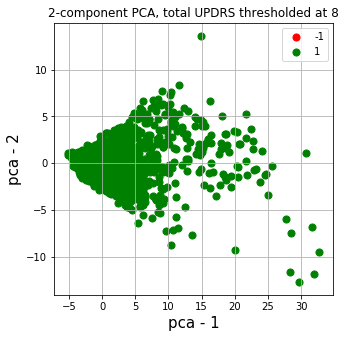

In [11]:
# PCA visualization (2 components)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)
pca_df = pd.DataFrame(data=pca_components, columns=['pca1','pca2'])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('pca - 1', fontsize=15)
ax.set_ylabel('pca - 2', fontsize=15)
ax.set_title('2-component PCA, total UPDRS thresholded at {}'.format(thresh), fontsize=12)

targets = [-1, 1]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indices_keep = Y == target
    ax.scatter(pca_df.loc[indices_keep, 'pca1'],
              pca_df.loc[indices_keep, 'pca2'],
              c=color,
              s=50)
ax.legend(targets)
ax.grid()
fig.savefig('')
fig.savefig('log_reg_total_thresh_{}.png'.format(thresh))

> Convert to DataFrame before running through a classifier

In [5]:
# convert ndarray to dataframes before running through classifiers
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

> Classifiers

In [ ]:
# 1. (Gaussian) Naive Bayes Classifier

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in k_fold.split(X,Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, Y_train).predict(X_test)
    print("Mislabeled %d points out of a total of %d points" % ((Y_test.values != y_pred).sum(), X_test.shape[0]))
    
    summary(Y_test, y_pred)
    disp = plot_confusion_matrix(gnb, X_test, Y_test, 
                                display_labels=np.unique(Y.values),
                                cmap=plt.cm.Blues,
                                normalize='true')
    disp.ax_.set_title('Confusion matrix')
    print("confusion matrix: \n",disp.confusion_matrix)
    plt.show()

In [ ]:
# 2. (Stratified 10-folded) SVM
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from svmutil import *

k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in k_fold.split(X,Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # define the svm problem
    prob = svm_problem(list(Y_train.values), list(X_train.values))
    
    param = svm_parameter("-q")
    param.svm_type = 0 # C-SVC
#     param.kernel_type = 0 # 0: Linear
    param.kernel_type = 2 #/ 2: RBF
    param.probability = 0 # disable probabiilty estimation, by default
    
    # apply grid search
    results = []
    for c in range(-5, 6):
        for g in range(-5, 6):
            param.C = 2**c
            param.gamma = 2**g
            m = svm_train(prob, param)
            p_label, p_acc, p_val = svm_predict(list(Y_test.values), list(X_test.values), m)
            results.append([2**c, 2**g, p_acc[0]])
    bestIdx = np.argmax(np.array(results)[:,2])
    best_c, best_g, _ = results[bestIdx]
    print("Best C: {}, Best Gamma: {}".format(best_c, best_g))
    
    # use best hyperparmaters to train
    param.C = best_c
    param.gamma = best_g
    
    m = svm_train(prob, param)
    y_pred, p_acc, p_val = svm_predict(list(Y_test.values), list(X_test.values), m)
        
    y_pred = pd.Series(y_pred)
    summary(Y_test, y_pred)
    cm = confusion_matrix(Y_test, y_pred, labels=np.unique(Y.values),normalize='true')
    print("confusion matrix: \n",cm)

In [ ]:
# (Stratified 10-folded) SVM (Different Error Cost (DEC))
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from svmutil import *
from sklearn.utils.class_weight import compute_class_weight

k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in k_fold.split(X,Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # define the svm problem
    prob = svm_problem(list(Y_train.values), list(X_train.values))
    
    # apply grid search
    results = []
    for c in range(-5, 6):
        for g in range(-5, 6):
            # adjust class weights by the ratio
            weights = compute_class_weight('balanced', classes=sorted(np.unique(Y_train)), y=Y_train.iloc[:,0])
            w_pos1, w_neg1 = weights
            # -s: svm_type (0 == C-SVC)
            # -b: probability estimate (0 == disabled)
            # -t: type of svm (0 == Linear, 2 == RBF)
            # -c: cost
            # -g: gamma
            # -w0, -w1: weights
            param = svm_parameter('-q -s 0 -b 0 -t 0 -c '+str(2**c)+' -g '+str(2**g)+' -w0 '+str(w_pos1)+' -w1 '+str(w_neg1))
            m = svm_train(prob, param)
            p_label, p_acc, p_val = svm_predict(list(Y_test.values), list(X_test.values), m)
            results.append([2**c, 2**g, p_acc[0]])
    bestIdx = np.argmax(np.array(results)[:,2])
    best_c, best_g, _ = results[bestIdx]
    print("Best C: {}, Best Gamma: {}".format(best_c, best_g))

    # test
    weights = compute_class_weight('balanced', classes=sorted(np.unique(Y_train)), y=Y_train.iloc[:,0])
    w_pos1, w_neg1 = weights
    print(sum(Y_train.values==1), sum(Y_train.values==-1)) # weights are in [1, -1] order            
    print("Class weights:",weights)
    param = svm_parameter('-q -s 0 -t 0 -c '+str(best_c)+' -g '+str(best_g)+' -w0 '+str(w_pos1)+' -w1 '+str(w_neg1))
    
    m = svm_train(prob, param)
    y_pred, p_acc, p_val = svm_predict(list(Y_test.values), list(X_test.values), m)
    
    y_pred = pd.Series(y_pred)
    summary(Y_test, y_pred)
    cm = confusion_matrix(Y_test, y_pred, labels=np.unique(Y.values),normalize='true')
    print("confusion matrix: \n",cm)

In [ ]:
# (Stratified 10-folded) SVM (DEC -- one-class learning)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from svmutil import *
from sklearn.utils.class_weight import compute_class_weight

k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in k_fold.split(X,Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # define the svm problem
    prob = svm_problem(list(Y_train.values), list(X_train.values))
    
    # apply grid search
    results = []
    for c in range(-5, 6):
        for g in range(-5, 6):
            # adjust class weights by the ratio
            weights = compute_class_weight('balanced', classes=sorted(np.unique(Y_train)), y=Y_train.iloc[:,0])
            w_pos1, w_neg1 = weights
            param = svm_parameter('-q -s 2 -b 0 -t 2 -c '+str(2**c)+' -g '+str(2**g)+' -w0 '+str(0)+' -w1 '+str(w_neg1))
            m = svm_train(prob, param)
            p_label, p_acc, p_val = svm_predict(list(Y_test.values), list(X_test.values), m)
            results.append([2**c, 2**g, p_acc[0]])
    bestIdx = np.argmax(np.array(results)[:,2])
    best_c, best_g, _ = results[bestIdx]
    print("Best C: {}, Best Gamma: {}".format(best_c, best_g))
    

    # test
    weights = compute_class_weight('balanced', classes=sorted(np.unique(Y_train)), y=Y_train.iloc[:,0])
    w_pos1, w_neg1 = weights
    print(sum(Y_train.values==1), sum(Y_train.values==-1)) # weights are in [1, -1] order            
    print("Class weights:",weights)
    param = svm_parameter('-q -s 2 -t 2 -c '+str(best_c)+' -g '+str(best_g)+' -w0 '+str(0)+' -w1 '+str(w_neg1))
    
    m = svm_train(prob, param)
    y_pred, p_acc, p_val = svm_predict(list(Y_test.values), list(X_test.values), m)
        
    y_pred = pd.Series(y_pred)
    summary(Y_test, -1*y_pred)
    cm = confusion_matrix(Y_test, y_pred, labels=np.unique(Y.values),normalize='true')
    print("confusion matrix: \n",cm)


In [ ]:
# 3. Logistic Regression
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# initialize model
logreg = LogisticRegressionCV(cv=10, solver='lbfgs',random_state=42)

# cross validated prediction
y_pred = logreg.fit(X_train, Y_train).predict(X_test)
summary(Y_test, y_pred)

disp = plot_confusion_matrix(logreg, X_test, Y_test, 
                            display_labels=np.unique(Y.values),
                            cmap=plt.cm.Blues,
                            normalize='true')
disp.ax_.set_title('Confusion matrix')
print("confusion matrix: \n",disp.confusion_matrix)
plt.show()

# plot logistic regression results with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)
x_min, x_max = pca_components[:,0].min() - 0.5, pca_components[:,0].max() + 0.5
y_min, y_max = pca_components[:,1].min() - 0.5, pca_components[:,1].max() + 0.5
h = 0.02 # mesh step size
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

logreg.fit(pca_components, Y)
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.pcolormesh(xx, yy, Z, cmap='binary_r') #plt.cm.Paired)

# plot also the training points
ax.scatter(pca_components[:,0], pca_components[:,1], c=Y.iloc[:,0]+1, edgecolors='r', cmap='binary_r') #plt.cm.Paired)
ax.set_xlabel('pca-1')
ax.set_ylabel('pca-2')
ax.set_title('Logistic Regression - total UPDRS thresholded at {}'.format(thresh))
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
plt.show()
fig.savefig('log_reg_total_thresh_{}.png'.format(thresh))

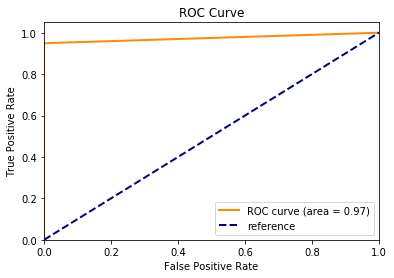

------summary statistics-------
acc: 0.9503 / balanced acc: 0.6386, AUC: 0.9747, F1: 0.9740, g-mean: 0.9743
confusion matrix: 
 [[1.         0.        ]
 [0.05065926 0.94934074]]


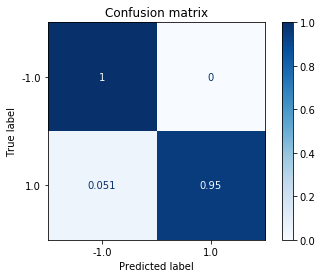

In [9]:
# 4. Ensemble classifier
# -- balanced bagging classifier (EasyEnsemble + BaggingClassifier)
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
bbc = BalancedBaggingClassifier(random_state=42)
y_pred = bbc.fit(X_train, Y_train).predict(X_test)

summary(Y_test, y_pred)

disp = plot_confusion_matrix(bbc, X_test, Y_test, 
                            display_labels=np.unique(Y.values),
                            cmap=plt.cm.Blues,
                            normalize='true')
disp.ax_.set_title('Confusion matrix')
print("confusion matrix: \n",disp.confusion_matrix)
plt.show()

> Ensemble Learning

In [ ]:
# 4. Ensemble classifier
# -- Boosting - RUSBoostClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

print(X.shape, Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
    
rusboost = RUSBoostClassifier(random_state=42)
rusboost.fit(X_train, Y_train)
y_pred = rusboost.predict(X_test)

summary(Y_test, y_pred)

disp = plot_confusion_matrix(rusboost, X_test, Y_test, 
                            display_labels=np.unique(Y.values),
                            cmap=plt.cm.Blues,
                            normalize='true')
disp.ax_.set_title('Confusion matrix')
print("confusion matrix: \n",disp.confusion_matrix)
plt.show()

In [ ]:
# 4. Ensemble classifier
# -- Boosting - EasyEnsemblerClassifier (AdaBoost)
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

print(X.shape, Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
    
eec = EasyEnsembleClassifier(random_state=42)
eec.fit(X_train, Y_train)
y_pred = eec.predict(X_test)

summary(Y_test, y_pred)

disp = plot_confusion_matrix(eec, X_test, Y_test, 
                            display_labels=np.unique(Y.values),
                            cmap=plt.cm.Blues,
                            normalize='true')
disp.ax_.set_title('Confusion matrix')
print("confusion matrix: \n",disp.confusion_matrix)
plt.show()